# Network Intrusion Detection System - NIDS

# 1. Prerequisites

## 1.1. Import Libraries

In [1]:
import os
import gc
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier
from tensorflow import keras
from prettytable import PrettyTable
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, root_mean_squared_error, mean_squared_error, mean_absolute_error, precision_score, confusion_matrix, multilabel_confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm
from sklearn.svm import LinearSVC

2024-11-28 14:00:54.326156: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732795254.355118   15131 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732795254.363711   15131 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 14:00:54.389098: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1.2. Define functions

In [2]:
def visualize_CM(matrix):
    """
    Visualize Correlation Matrix
    """
    sns.heatmap(matrix,annot=True)

def missing_values(df):
    """
    Print a table with missing values
    """
    table = PrettyTable(["Column", "All Values", "Missing Values", "% of missing values"])
    NaN_columns = []
    columns = df.columns
    for column in columns:
        all_values = df[column].count()
        missing_values = df[column].isna().sum()
        if missing_values > 0:
            NaN_columns.append(column)
        percentage = f'{(missing_values / all_values)*100:.2f}'
        table.add_row([column, all_values, missing_values, f'{percentage}%'])
    data = table.get_string()
    #with open(f"Missing_table.txt", 'w') as f:
    #    f.write(data)
    print(table)
    if len(NaN_columns) > 0:
        print(f"Columns with missing values: {NaN_columns}")
    #print(f"Table saved as Missing_table.txt")

def hist_plot(label, count):
    _dict = {}
    for x in range(len(label)):
        _dict[label[x]] = count.iloc[x]
    fig, ax = plt.subplots(figsize=(10,10))
    ax.bar(_dict.keys(), _dict.values())
    ax.set_title('Network traffic type distribution', fontsize=16, fontweight="bold")
    ax.set_xlabel('Network traffic type')
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_ylabel('Distribution')
    ax.grid(which='Major', axis='both')
    #plt.savefig("Traffic_type_distribution.png")

def attack_plot(label, count):
    _dict = {}
    label = [x for x in label if x != 'BENIGN']
    count = count.iloc[1:len(count)]
    for x in range(len(label)):
        _dict[label[x]] = count.iloc[x]
    fig, ax = plt.subplots(figsize=(10,10))
    ax.bar(_dict.keys(), _dict.values())
    ax.set_title('Attack type distribution', fontsize=16, fontweight="bold")
    ax.set_xlabel('Traffic type')
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_ylabel('Distribution')
    ax.grid(which='Major', axis='both')
    #plt.savefig("attack_type_distribution.png")

def plotResults(df, columns_list, rows, columns):
    """
    Plot results
    """
    fig, axes = plt.subplots(rows, columns)
    for ax, col in zip(axes.ravel(), columns_list):
        df[col].plot(ax=ax,
                     kind="bar",
                     figsize=(15,50),
                     fontsize=12)
        if col in ["Accuracy", "Precision", "F1", "Recall"]:
            ax.set_title(f"{col} (Higher is better)", fontsize=20)
        else:
            ax.set_title(f"{col} (Lower is better)", fontsize=20)
        ax.tick_params(axis='x', labelrotation=0)

In [3]:
for dirname, _, filenames in os.walk('data/CIC_IDS_2017/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/CIC_IDS_2017/prepared_train_data.npy
data/CIC_IDS_2017/prepared_train_labels.npy
data/CIC_IDS_2017/README.md
data/CIC_IDS_2017/download_dataset.sh
data/CIC_IDS_2017/TrafficLabelling/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
data/CIC_IDS_2017/TrafficLabelling/Wednesday-workingHours.pcap_ISCX.csv
data/CIC_IDS_2017/TrafficLabelling/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
data/CIC_IDS_2017/TrafficLabelling/Monday-WorkingHours.pcap_ISCX.csv
data/CIC_IDS_2017/TrafficLabelling/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
data/CIC_IDS_2017/TrafficLabelling/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
data/CIC_IDS_2017/TrafficLabelling/Tuesday-WorkingHours.pcap_ISCX.csv
data/CIC_IDS_2017/TrafficLabelling/Friday-WorkingHours-Morning.pcap_ISCX.csv
data/CIC_IDS_2017/MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
data/CIC_IDS_2017/MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv
data/CIC_IDS_2017/MachineLearningCVE/Thursd

# 2. Data Analysis

In [4]:
monday = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv', sep=",", encoding='utf-8')
tuesday = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv', sep=",", encoding='utf-8')
wednesday = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv', sep=",", encoding='utf-8')
thursday_morning = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', sep=",", encoding='utf-8')
thursday_afternoon = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv', sep=",", encoding='utf-8')
friday_ddos = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv', sep=",", encoding='utf-8')
friday_pcap = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv', sep=",", encoding='utf-8')
friday_morning = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Friday-WorkingHours-Morning.pcap_ISCX.csv', sep=",", encoding='utf-8')
monday.name = 'Monday'
tuesday.name = 'Tuesday'
wednesday.name = 'Wednesday'
thursday_morning.name = 'Thursday_Morning'
thursday_afternoon.name = 'Thursday_Afternoon'
friday_ddos.name = 'Friday_DDoS'
friday_pcap.name = 'Friday_Pcap'
friday_morning.name = 'Friday_Morning'

In [5]:
dataframes = [monday, tuesday, wednesday, thursday_morning, thursday_afternoon, friday_ddos, friday_morning, friday_pcap]
data = pd.concat(dataframes)

In [6]:
data.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,49188,4,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,49486,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2830743 entries, 0 to 286466
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max               

In [8]:
data.columns

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

In [9]:
data[' Label'].unique()

array(['BENIGN', 'FTP-Patator', 'SSH-Patator', 'DoS slowloris',
       'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye', 'Heartbleed',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'Infiltration', 'DDoS', 'Bot',
       'PortScan'], dtype=object)

In [10]:
data[' Label'].value_counts()

 Label
BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

In [11]:
data = data.replace([-np.inf, np.inf], np.nan)
missing_values(data)

+------------------------------+------------+----------------+---------------------+
|            Column            | All Values | Missing Values | % of missing values |
+------------------------------+------------+----------------+---------------------+
|       Destination Port       |  2830743   |       0        |        0.00%        |
|         Flow Duration        |  2830743   |       0        |        0.00%        |
|       Total Fwd Packets      |  2830743   |       0        |        0.00%        |
|    Total Backward Packets    |  2830743   |       0        |        0.00%        |
| Total Length of Fwd Packets  |  2830743   |       0        |        0.00%        |
|  Total Length of Bwd Packets |  2830743   |       0        |        0.00%        |
|     Fwd Packet Length Max    |  2830743   |       0        |        0.00%        |
|     Fwd Packet Length Min    |  2830743   |       0        |        0.00%        |
|    Fwd Packet Length Mean    |  2830743   |       0        |   

In [12]:
data.dropna(inplace=True)
missing_values(data)

+------------------------------+------------+----------------+---------------------+
|            Column            | All Values | Missing Values | % of missing values |
+------------------------------+------------+----------------+---------------------+
|       Destination Port       |  2827876   |       0        |        0.00%        |
|         Flow Duration        |  2827876   |       0        |        0.00%        |
|       Total Fwd Packets      |  2827876   |       0        |        0.00%        |
|    Total Backward Packets    |  2827876   |       0        |        0.00%        |
| Total Length of Fwd Packets  |  2827876   |       0        |        0.00%        |
|  Total Length of Bwd Packets |  2827876   |       0        |        0.00%        |
|     Fwd Packet Length Max    |  2827876   |       0        |        0.00%        |
|     Fwd Packet Length Min    |  2827876   |       0        |        0.00%        |
|    Fwd Packet Length Mean    |  2827876   |       0        |   

In [13]:
label = data[' Label'].value_counts().index.tolist()
count = data[' Label'].value_counts()

In [14]:
label

['BENIGN',
 'DoS Hulk',
 'PortScan',
 'DDoS',
 'DoS GoldenEye',
 'FTP-Patator',
 'SSH-Patator',
 'DoS slowloris',
 'DoS Slowhttptest',
 'Bot',
 'Web Attack � Brute Force',
 'Web Attack � XSS',
 'Infiltration',
 'Web Attack � Sql Injection',
 'Heartbleed']

In [15]:
count

 Label
BENIGN                        2271320
DoS Hulk                       230124
PortScan                       158804
DDoS                           128025
DoS GoldenEye                   10293
FTP-Patator                      7935
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1956
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

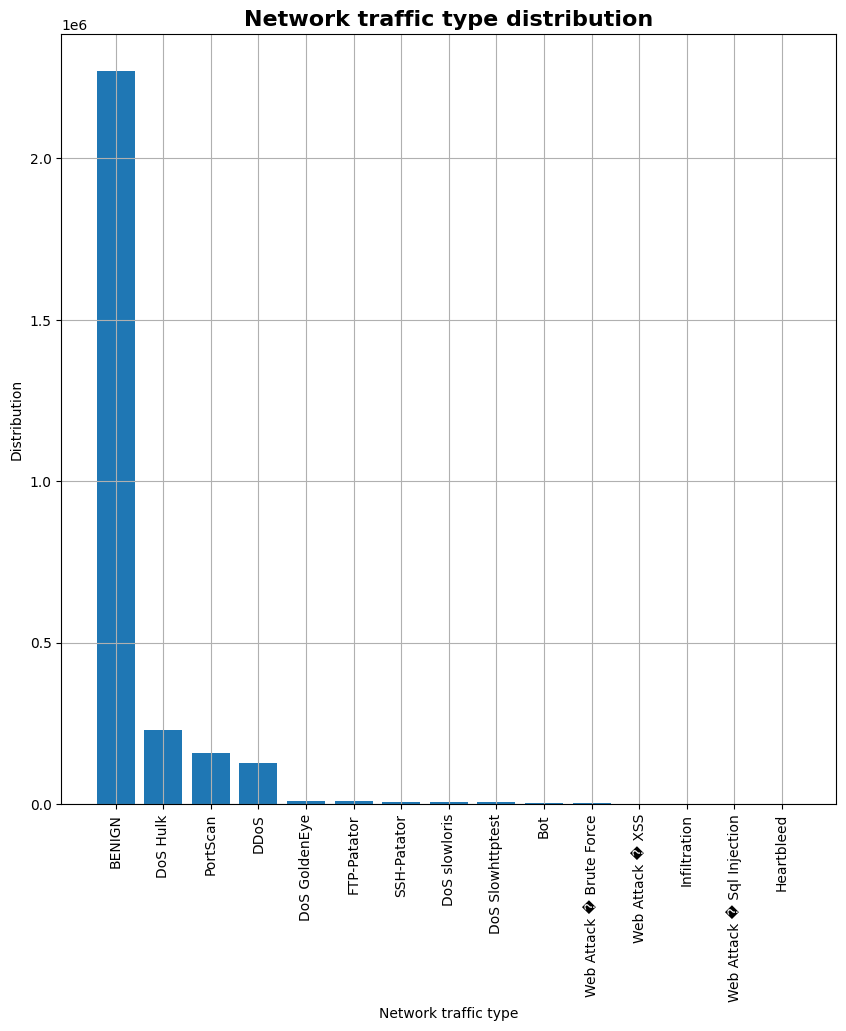

In [16]:
hist_plot(label, count)

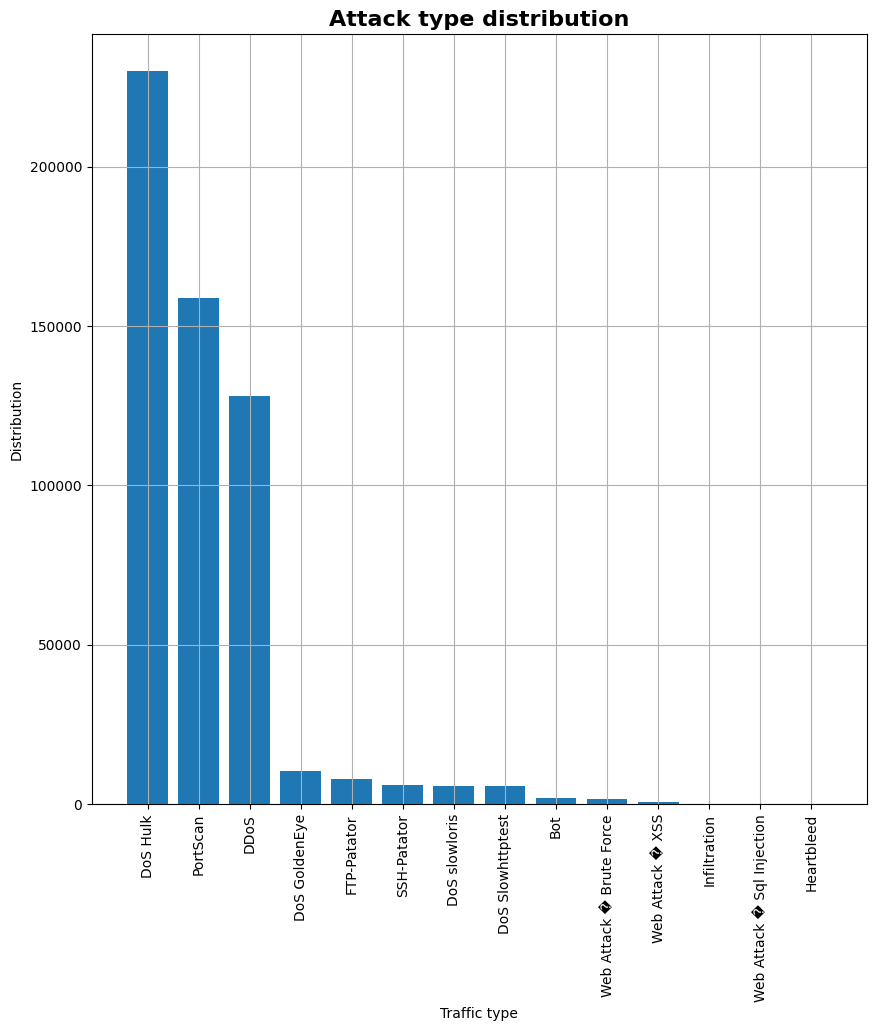

In [17]:
attack_plot(label, count)

# 4. Prepare data

In [18]:
X = data.drop([' Label'], axis=1)
y = data[' Label']

In [19]:
X.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,49188,4,2,0,12,0,6,6,6.0,0.0,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
1,49188,1,2,0,12,0,6,6,6.0,0.0,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
2,49188,1,2,0,12,0,6,6,6.0,0.0,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
3,49188,1,2,0,12,0,6,6,6.0,0.0,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
4,49486,3,2,0,12,0,6,6,6.0,0.0,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0


In [20]:
y.unique()

array(['BENIGN', 'FTP-Patator', 'SSH-Patator', 'DoS slowloris',
       'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye', 'Heartbleed',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'Infiltration', 'DDoS', 'Bot',
       'PortScan'], dtype=object)

In [21]:
len(y.unique())

15

## 4.1 Data Normalization

In [22]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [23]:
X

array([[ 2.25050642, -0.43961241, -0.00982461, ..., -0.10951643,
        -0.35707153, -0.33918443],
       [ 2.25050642, -0.4396125 , -0.00982461, ..., -0.10951643,
        -0.35707153, -0.33918443],
       [ 2.25050642, -0.4396125 , -0.00982461, ..., -0.10951643,
        -0.35707153, -0.33918443],
       ...,
       [-0.41689841, -0.4348067 ,  0.08083571, ..., -0.10951643,
        -0.35707153, -0.33918443],
       [-0.41689841, -0.43536915,  0.05417091, ..., -0.10951643,
        -0.35707153, -0.33918443],
       [-0.41689841, -0.43406035,  0.04883795, ..., -0.10951643,
        -0.35707153, -0.33918443]])

## 4.2 Encode data

In [24]:
onehotencoder = OneHotEncoder()
y = y.values.reshape(-1, 1)
y = onehotencoder.fit_transform(y).toarray()
y = y[:, 0]

In [25]:
y

array([1., 1., 1., ..., 1., 1., 1.])

## 4.3 Principal component analysis

In [26]:
%%time
num_components = 10
pca = PCA(n_components=num_components)
X_pca = pca.fit_transform(X)
feature_selector = SelectKBest(score_func=f_classif, k='all')
X = feature_selector.fit_transform(X_pca, y)
X = X.reshape(X.shape[0], num_components, 1)

CPU times: user 4.25 s, sys: 1.35 s, total: 5.6 s
Wall time: 1.54 s


## 4.4 Save data

In [27]:
np.save('data/CIC_IDS_2017/prepared_train_data.npy', X)
np.save('data/CIC_IDS_2017/prepared_train_labels.npy', y)

## 4.5 Load data

In [28]:
X = np.load('data/CIC_IDS_2017/prepared_train_data.npy')
y = np.load('data/CIC_IDS_2017/prepared_train_labels.npy')

In [29]:
X

array([[[-2.20341917],
        [-0.04649812],
        [ 0.5388577 ],
        ...,
        [-0.18823211],
        [-0.24876228],
        [ 1.3845989 ]],

       [[-2.65783247],
        [-0.06213898],
        [ 0.80433841],
        ...,
        [ 0.16800908],
        [ 1.10542934],
        [-1.99055778]],

       [[-2.65783247],
        [-0.06213898],
        [ 0.80433841],
        ...,
        [ 0.16800908],
        [ 1.10542934],
        [-1.99055778]],

       ...,

       [[ 2.96579199],
        [ 0.59986647],
        [-5.2269146 ],
        ...,
        [ 2.82679641],
        [ 0.33933268],
        [-0.2927417 ]],

       [[ 2.00624895],
        [ 0.45068367],
        [-4.21600076],
        ...,
        [ 2.46204332],
        [-0.01862949],
        [-0.30590085]],

       [[ 1.99913966],
        [ 0.43758331],
        [-4.20599781],
        ...,
        [ 2.45912152],
        [-0.02805093],
        [-0.30215974]]])

In [30]:
y

array([1., 1., 1., ..., 1., 1., 1.])

# 5. Create a model

Testing these models:
1. K Nearest Neighbour
2. Random Forest
3. Gradient Boost:
    * XGBoost;
    * CatBoost;
    * LightGBM.
4. Support Vector Machine;
5. Neural Network.

In [31]:
results_dict = {}

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2403694, 10), (2403694,), (424182, 10), (424182,))

## 5.1. K Nearest Neighbour

In [33]:
%%time

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
y_pred = knn_clf.predict(X_test)

CPU times: user 42.6 s, sys: 128 ms, total: 42.7 s
Wall time: 43.1 s


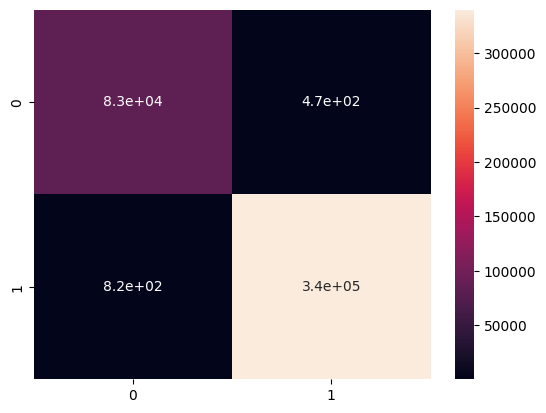

In [34]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [35]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [36]:
results = [accuracy, precision, f1, recall, mae, mse, rmse]
results_dict["KNN"] = results

In [37]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MAE", "MSE", "RMSE"])

,Accuracy,Precision,F1,Recall,MAE,MSE,RMSE
KNN,0.996949,0.996956,0.996952,0.996949,0.003051,0.003051,0.055232


## 5.2. Random Forest

In [38]:
%%time

rf_clf = RandomForestClassifier(n_jobs=8)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

CPU times: user 30min 47s, sys: 6.09 s, total: 30min 53s
Wall time: 4min 31s


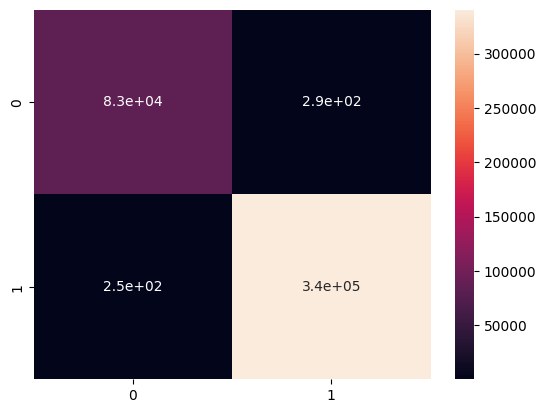

In [39]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [40]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [41]:
results = [accuracy, precision, f1, recall, mae, mse, rmse]
results_dict["RF"] = results

In [42]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MAE", "MSE", "RMSE"])

,Accuracy,Precision,F1,Recall,MAE,MSE,RMSE
KNN,0.996949,0.996956,0.996952,0.996949,0.003051,0.003051,0.055232
RF,0.998727,0.998727,0.998727,0.998727,0.001273,0.001273,0.035680


## 5.3. XGBoost

In [43]:
%%time

xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

CPU times: user 1min 28s, sys: 317 ms, total: 1min 28s
Wall time: 15.4 s


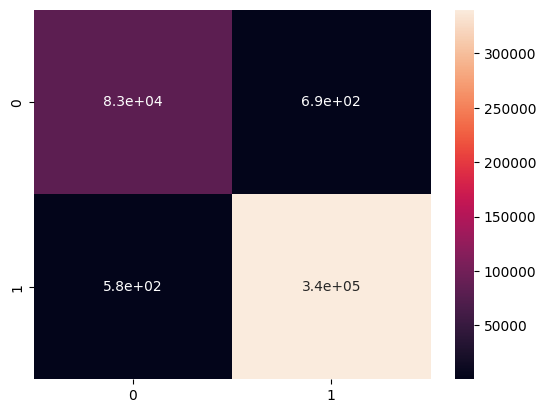

In [44]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [45]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [46]:
results = [accuracy, precision, f1, recall, mae, mse, rmse]
results_dict["XGBoost"] = results

In [47]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MAE", "MSE", "RMSE"])

,Accuracy,Precision,F1,Recall,MAE,MSE,RMSE
KNN,0.996949,0.996956,0.996952,0.996949,0.003051,0.003051,0.055232
RF,0.998727,0.998727,0.998727,0.998727,0.001273,0.001273,0.035680
XGBoost,0.997008,0.997007,0.997008,0.997008,0.002992,0.002992,0.054696


## 5.4. LightGBM

In [48]:
%%time

lgbm_clf = lightgbm.LGBMClassifier()
lgbm_clf.fit(X_train, y_train)
y_pred = lgbm_clf.predict(X_test)

[LightGBM] [Info] Number of positive: 1930602, number of negative: 473092
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 2403694, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.803181 -> initscore=1.406297
[LightGBM] [Info] Start training from score 1.406297
CPU times: user 35.4 s, sys: 71.3 ms, total: 35.5 s
Wall time: 9.21 s


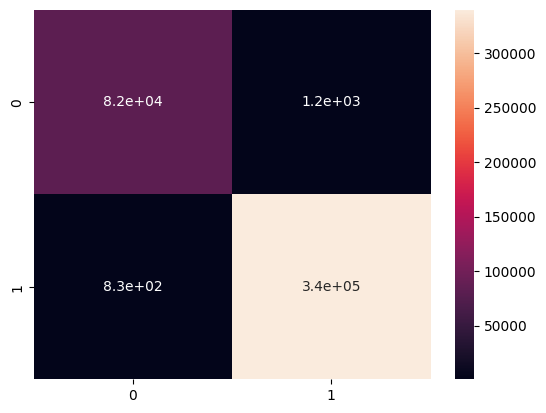

In [49]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [50]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [51]:
results = [accuracy, precision, f1, recall, mae, mse, rmse]
results_dict["LightGBM"] = results

In [52]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MAE", "MSE", "RMSE"])

,Accuracy,Precision,F1,Recall,MAE,MSE,RMSE
KNN,0.996949,0.996956,0.996952,0.996949,0.003051,0.003051,0.055232
RF,0.998727,0.998727,0.998727,0.998727,0.001273,0.001273,0.035680
XGBoost,0.997008,0.997007,0.997008,0.997008,0.002992,0.002992,0.054696
LightGBM,0.995120,0.995114,0.995115,0.995120,0.004880,0.004880,0.069857


## 5.5. Linear Support Vector Classifier

In [53]:
%%time

svc_clf = LinearSVC()
svc_clf.fit(X_train, y_train)
y_pred = svc_clf.predict(X_test)

CPU times: user 7.34 s, sys: 107 ms, total: 7.45 s
Wall time: 7.5 s


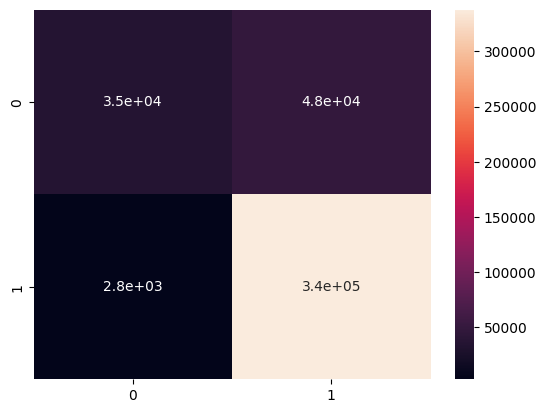

In [54]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [55]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [56]:
results = [accuracy, precision, f1, recall, mae, mse, rmse]
results_dict["LSVC"] = results

In [57]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MAE", "MSE", "RMSE"]).T

,KNN,RF,XGBoost,LightGBM,LSVC
Accuracy,0.996949,0.998727,0.997008,0.995120,0.879146
Precision,0.996956,0.998727,0.997007,0.995114,0.884560
F1,0.996952,0.998727,0.997008,0.995115,0.860235
Recall,0.996949,0.998727,0.997008,0.995120,0.879146
MAE,0.003051,0.001273,0.002992,0.004880,0.120854
MSE,0.003051,0.001273,0.002992,0.004880,0.120854
RMSE,0.055232,0.035680,0.054696,0.069857,0.347640


## 5.6. Neural Network

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1971029, 10, 1),
 (1971029,),
 (432665, 10, 1),
 (432665,),
 (424182, 10, 1),
 (424182,))

In [59]:
def create_model(X_train, y_train):
    model = keras.Sequential()
    model.add(keras.layers.Dense(X_train.shape[1], activation='relu', input_shape=(X_train.shape[1],)))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dense(len(np.unique(y_train)), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
model = create_model(X_train, y_train)

/home/kostas/Documents/git/IDS_test/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1732795635.824876   15131 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4683 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1


In [60]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │           2,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,232 (270.44 KB)

 Trainable params: 69,232 (270.44 KB)

 Non-trainable params: 0 (0.00 B)

In [61]:
%%time
model.fit(X_train, y_train,
          batch_size=32,
          epochs=20,
          validation_data=(X_val, y_val))
gc.collect();

Epoch 1/20


I0000 00:00:1732795638.219533   23371 service.cc:148] XLA service 0x74d3cc0063a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732795638.219552   23371 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1060, Compute Capability 6.1
2024-11-28 14:07:18.258584: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732795638.395727   23371 cuda_dnn.cc:529] Loaded cuDNN version 90501


   69/61595 ━━━━━━━━━━━━━━━━━━━━ 2:18 2ms/step - accuracy: 0.8119 - loss: 0.4513

I0000 00:00:1732795639.283813   23371 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


61595/61595 ━━━━━━━━━━━━━━━━━━━━ 150s 2ms/step - accuracy: 0.9610 - loss: 0.0912 - val_accuracy: 0.9744 - val_loss: 0.0572
Epoch 2/20
61595/61595 ━━━━━━━━━━━━━━━━━━━━ 135s 2ms/step - accuracy: 0.9753 - loss: 0.0556 - val_accuracy: 0.9771 - val_loss: 0.0544
Epoch 3/20
61595/61595 ━━━━━━━━━━━━━━━━━━━━ 134s 2ms/step - accuracy: 0.9772 - loss: 0.0522 - val_accuracy: 0.9798 - val_loss: 0.0470
Epoch 4/20
61595/61595 ━━━━━━━━━━━━━━━━━━━━ 132s 2ms/step - accuracy: 0.9814 - loss: 0.0441 - val_accuracy: 0.9751 - val_loss: 0.0532
Epoch 5/20
61595/61595 ━━━━━━━━━━━━━━━━━━━━ 135s 2ms/step - accuracy: 0.9861 - loss: 0.0358 - val_accuracy: 0.9894 - val_loss: 0.0281
Epoch 6/20
61595/61595 ━━━━━━━━━━━━━━━━━━━━ 134s 2ms/step - accuracy: 0.9874 - loss: 0.0330 - val_accuracy: 0.9905 - val_loss: 0.0264
Epoch 7/20
61595/61595 ━━━━━━━━━━━━━━━━━━━━ 132s 2ms/step - accuracy: 0.9877 - loss: 0.0320 - val_accuracy: 0.9879 - val_loss: 0.0337
Epoch 8/20
61595/61595 ━━━━━━━━━━━━━━━━━━━━ 133s 2ms/step - accuracy: 0.9

In [62]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

13256/13256 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step


In [63]:
_, accuracy = model.evaluate(X_test, y_test)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

13256/13256 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9924 - loss: 0.0253


In [64]:
results = [accuracy, precision, f1, recall, mae, mse, rmse]
results_dict["RNN"] = results

In [69]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MAE", "MSE", "RMSE"])

# 6. Plotting data

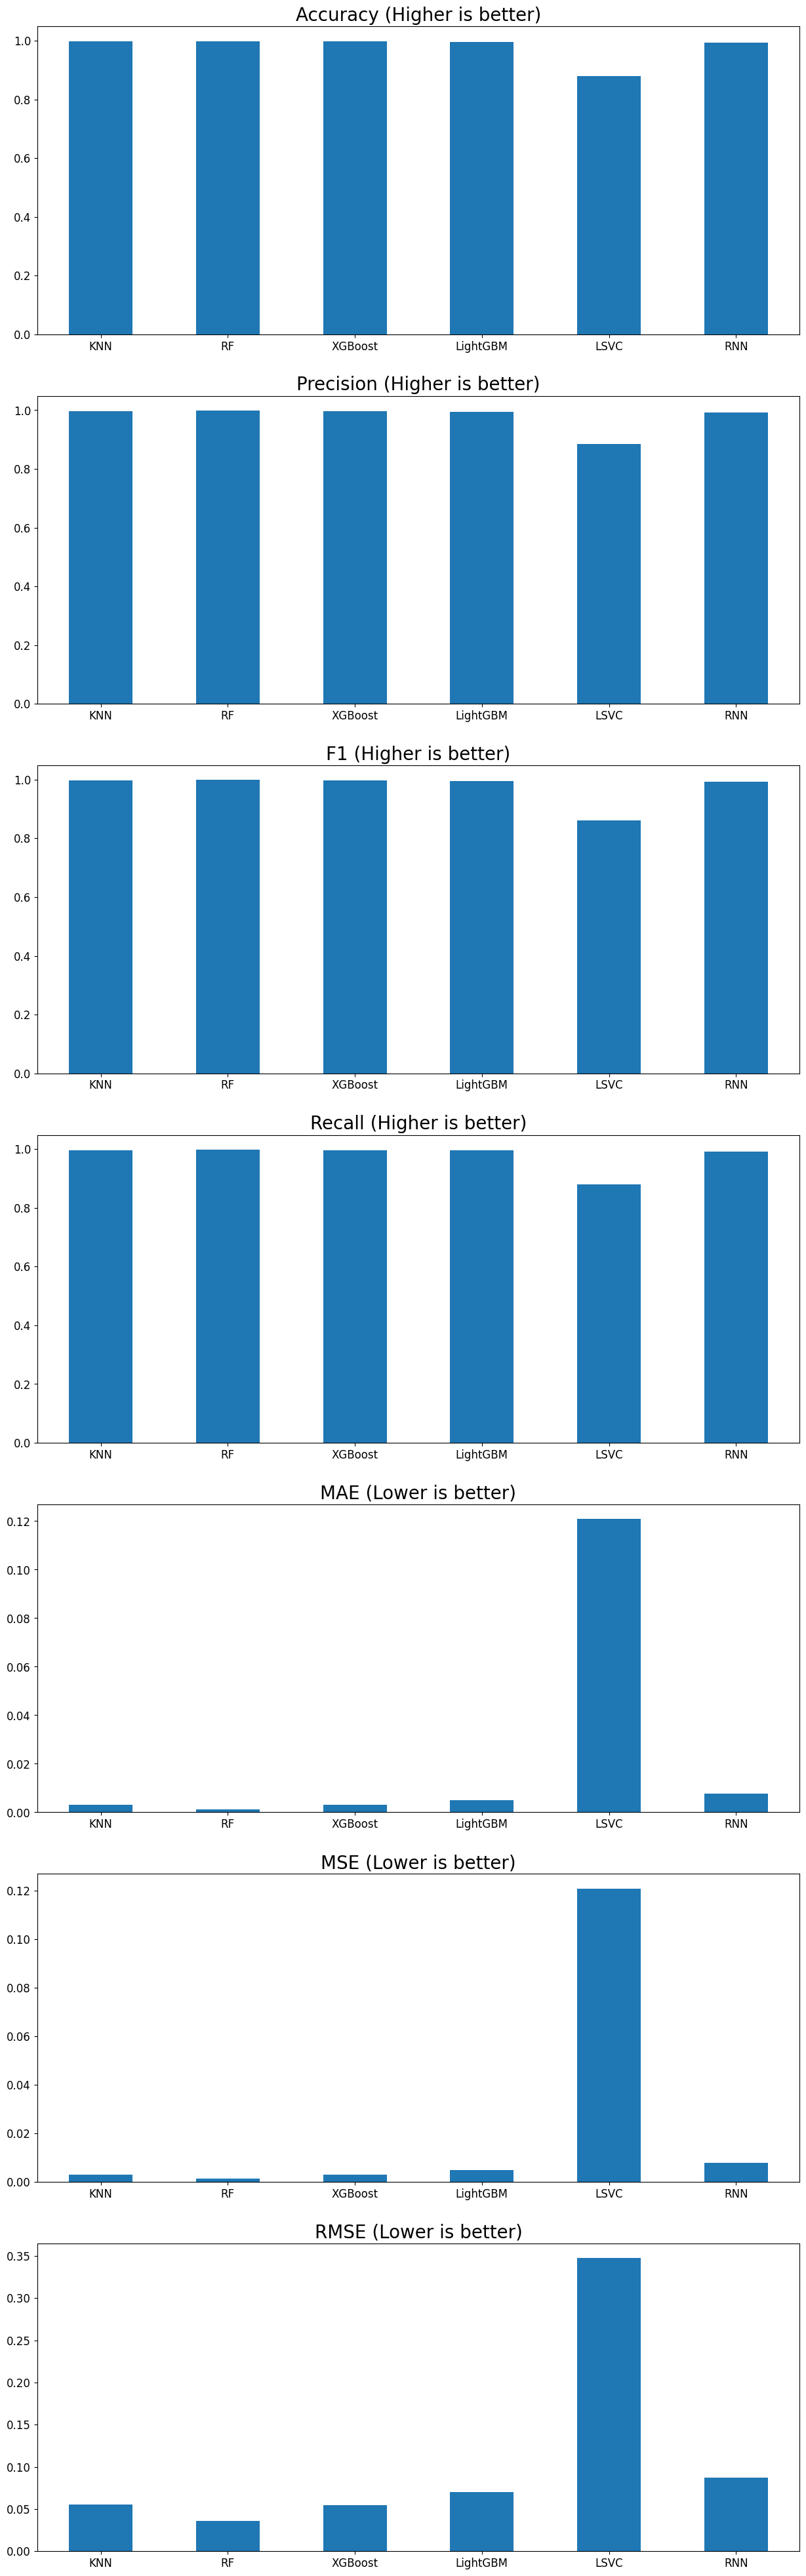

In [70]:
plotResults(results_df, results_df.columns, len(results_df.columns), 1)